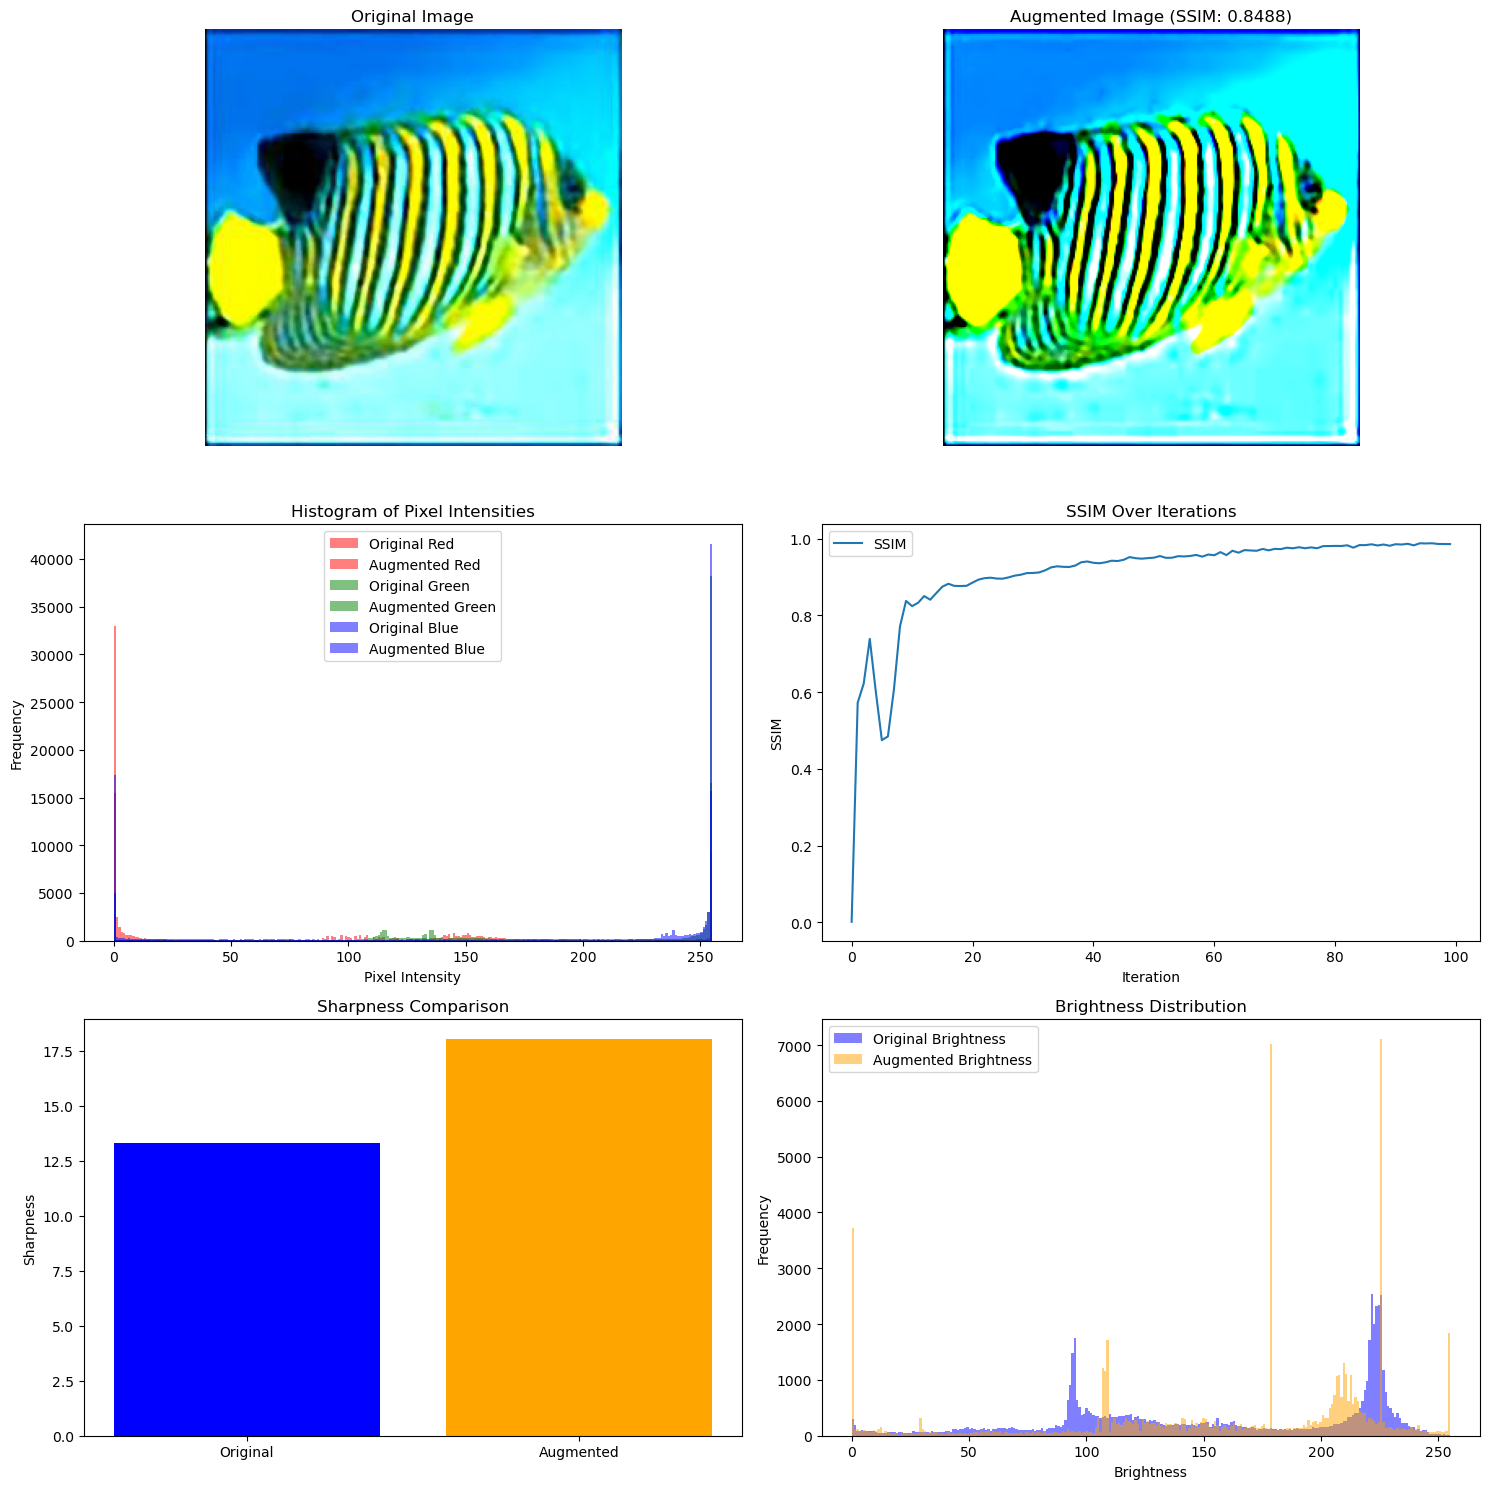

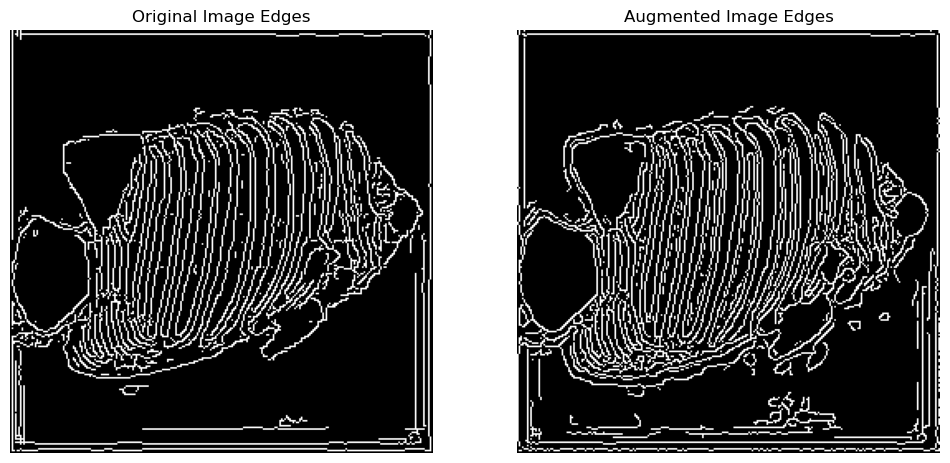

Saved augmented image as augmented_augmented_n02606052_19675.jpg
SSIM: 0.8488


In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import vgg16
from skimage.metrics import structural_similarity as ssim
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
from scipy.stats import entropy
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
])

class DreamBooth(nn.Module):
    def __init__(self):
        super(DreamBooth, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x

class VGGFeatures(nn.Module):
    def __init__(self):
        super(VGGFeatures, self).__init__()
        vgg = vgg16(pretrained=True).features
        self.slice = nn.Sequential(*list(vgg)[:16])  
    def forward(self, x):
        return self.slice(x)

def stable_diffusion_augmentation(image, n_iterations=100, initial_sigma=0.1):
    image_tensor = transform(image).unsqueeze(0).to(device)
    model = DreamBooth().to(device)
    vgg_features = VGGFeatures().to(device)
    for param in vgg_features.parameters():
        param.requires_grad = False

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    ssim_values = []

    for iteration in range(n_iterations):
        sigma = initial_sigma * (1 - iteration / n_iterations)
        noise = torch.randn_like(image_tensor) * sigma
        perturbed_image = image_tensor + noise

        optimizer.zero_grad()
        output = model(perturbed_image)
        
        l2_loss = torch.norm(output - perturbed_image)
        perceptual_loss = torch.norm(vgg_features(output) - vgg_features(image_tensor))
        loss = l2_loss + 0.01 * perceptual_loss  
        
        loss.backward()
        optimizer.step()

        output_image = output.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
        output_image = np.clip(output_image, 0, 1)
        output_image_pil = Image.fromarray((output_image * 255).astype(np.uint8))
        ssim_values.append(calculate_ssim(image, output_image_pil))

    augmented_image = output.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    augmented_image = np.clip(augmented_image, 0, 1) 

    augmented_image_pil = Image.fromarray((augmented_image * 255).astype(np.uint8))

    enhancer = ImageEnhance.Color(augmented_image_pil)
    augmented_image_pil = enhancer.enhance(1.5)  
    
    enhancer = ImageEnhance.Brightness(augmented_image_pil)
    augmented_image_pil = enhancer.enhance(1.2) 

    enhancer = ImageEnhance.Contrast(augmented_image_pil)
    augmented_image_pil = enhancer.enhance(1.2)  

    augmented_image_pil = augmented_image_pil.filter(ImageFilter.UnsharpMask(radius=2, percent=200, threshold=3))

    augmented_image_pil = augmented_image_pil.filter(ImageFilter.MedianFilter(size=3))

    return augmented_image_pil, ssim_values


def select_files():
    root = tk.Tk()
    root.withdraw() 
    file_paths = filedialog.askopenfilenames()  
    root.destroy()  
    return file_paths

def select_output_directory():
    root = tk.Tk()
    root.withdraw()  
    directory_path = filedialog.askdirectory()  
    root.destroy()  
    return directory_path

def calculate_ssim(image1, image2):
    gray1 = np.array(image1.convert('L'))
    gray2 = np.array(image2.convert('L'))
    return ssim(gray1, gray2, data_range=gray2.max() - gray2.min())

def calculate_sharpness(image):
    image = image.convert('L')  
    image_array = np.array(image, dtype=np.float32)
    gradient_x = np.diff(image_array, axis=1)
    gradient_y = np.diff(image_array, axis=0)
    sharpness = np.sqrt(gradient_x[:-1, :]**2 + gradient_y[:, :-1]**2).mean()
    return sharpness

file_paths = select_files()
output_directory = select_output_directory()

if file_paths and output_directory:
    for file_path in file_paths:
        image = Image.open(file_path).convert('RGB')
        
        augmented_image, ssim_values = stable_diffusion_augmentation(image)

        ssim_value = calculate_ssim(image, augmented_image)

        original_sharpness = calculate_sharpness(image)
        augmented_sharpness = calculate_sharpness(augmented_image)

        fig, axs = plt.subplots(3, 2, figsize=(15, 15))
        axs[0, 0].imshow(image)
        axs[0, 0].set_title('Original Image')
        axs[0, 0].axis('off')
        
        axs[0, 1].imshow(augmented_image)
        axs[0, 1].set_title(f'Augmented Image (SSIM: {ssim_value:.4f})')
        axs[0, 1].axis('off')

        channels = ['Red', 'Green', 'Blue']
        for i, color in enumerate(['r', 'g', 'b']):
            axs[1, 0].hist(np.array(image)[:, :, i].flatten(), bins=256, alpha=0.5, color=color, label=f'Original {channels[i]}')
            axs[1, 0].hist(np.array(augmented_image)[:, :, i].flatten(), bins=256, alpha=0.5, color=color, linestyle='dashed', label=f'Augmented {channels[i]}')
        
        axs[1, 0].set_title('Histogram of Pixel Intensities')
        axs[1, 0].set_xlabel('Pixel Intensity')
        axs[1, 0].set_ylabel('Frequency')
        axs[1, 0].legend()
        
        axs[1, 1].plot(ssim_values, label='SSIM')
        axs[1, 1].set_title('SSIM Over Iterations')
        axs[1, 1].set_xlabel('Iteration')
        axs[1, 1].set_ylabel('SSIM')
        axs[1, 1].legend()

        axs[2, 0].bar(['Original', 'Augmented'], [original_sharpness, augmented_sharpness], color=['blue', 'orange'])
        axs[2, 0].set_title('Sharpness Comparison')
        axs[2, 0].set_ylabel('Sharpness')

        original_brightness = np.array(image.convert('L')).flatten()
        augmented_brightness = np.array(augmented_image.convert('L')).flatten()
        axs[2, 1].hist(original_brightness, bins=256, alpha=0.5, color='blue', label='Original Brightness')
        axs[2, 1].hist(augmented_brightness, bins=256, alpha=0.5, color='orange', label='Augmented Brightness')
        axs[2, 1].set_title('Brightness Distribution')
        axs[2, 1].set_xlabel('Brightness')
        axs[2, 1].set_ylabel('Frequency')
        axs[2, 1].legend()

        plt.tight_layout()
        plt.show()
        
        original_image_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        augmented_image_bgr = cv2.cvtColor(np.array(augmented_image), cv2.COLOR_RGB2BGR)
        original_edges = cv2.Canny(original_image_bgr, 100, 200)
        augmented_edges = cv2.Canny(augmented_image_bgr, 100, 200)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_edges, cmap='gray')
        plt.title('Original Image Edges')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(augmented_edges, cmap='gray')
        plt.title('Augmented Image Edges')
        plt.axis('off')

        plt.show()


        augmented_image.save(os.path.join(output_directory, 'augmented_' + os.path.basename(file_path)))
        print(f'Saved augmented image as augmented_{os.path.basename(file_path)}')
        print(f'SSIM: {ssim_value:.4f}')
else:
    print("No files selected or no output directory specified.")
